<a href="https://colab.research.google.com/github/naikasann/Keras_tutorial/blob/master/NeuralNetwork_tutorial_3_Mynet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kerasを触ってみる(第3章 自分のデータセットを学習してみる)

次は自分でデータセットを作成してそれを学習してみましょう。
今回は動画を２パターン(○○がある、○○がない)を撮影して毎フレームを画像にして学習し、画像に○○があるのかないのか判別するニューラルネットワークを作成してみましょう。

---

# 動画から画像を取り出してみる

まずは動画から画像を取り出してみましょう。

---

## 動画を画像に変換する。

動画から全フレームを画像に保存する関数を作成し、その後動画をアップロードその関数を実行して画像を作成しましょう。まずは動画をフレーム毎に区切り画像にするメソッドを作成します。

In [1]:
# 動画を画像にする関数の定義

# ライブラリのインポート
import cv2
import os
from PIL import Image

def save_all_frames(video_path, dir_path, savename, ext="jpg"):
    # 動画を読み取る
    cap = cv2.VideoCapture(video_path)

    # 読めこめなかった場合
    if not cap.isOpened():
        print("cant open.")
        return None
    # フォルダーの作成
    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, savename)

    # フレームを取り出す
    frames = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))
    n = 0

    while True:
        # フレームから情報を取得する
        ret, frame = cap.read()
        if ret:
            # 画像を生成。保存する(その時にリサイズもかけておく)
            frame = cv2.resize(frame, (224, 224))
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(frames), ext), frame)
            n += 1
        else:
            return None

このようなメソッドで動画を画像にすることができます。
ただこのやり方だと区切りが早すぎて同じような画像が多く出現するため、実際に動画から抽出する場合はもう少し工夫をした方がいい結果になります。

---
## 動画をアップロードしてみよう

次に動画をアップデートしましょう。またアップロードされた動画から画像に切り出すメソッドも実行しましょう。
たくさんの画像が生成されることがわかると思います。

まずはmp4が対応しているのでmp4の動画をアップロードしてみましょう。
ここはgoogle colabの機能などを利用しているだけなのであまり覚えなくていいです。


In [2]:
# ２つの動画のアップロード

from google.colab import files

print("１つ目の動画を選択してください")
uploaded = files.upload()
print("2つ目の動画を選択してください")
uploaded = files.upload()

print("meke directory dataset...")
!mkdir dataset
print("category1 folder make...")
!mkdir ./dataset/category1
print("category2 folder make...")
!mkdir ./dataset/category2
!ls -l

１つ目の動画を選択してください


Saving midori.mp4 to midori.mp4
2つ目の動画を選択してください


Saving murasaki.mp4 to murasaki.mp4
meke directory dataset...
category1 folder make...
category2 folder make...
total 25436
drwxr-xr-x 4 root root     4096 Jul  8 03:53 dataset
-rw-r--r-- 1 root root 12366188 Jul  8 03:49 midori.mp4
-rw-r--r-- 1 root root 13664876 Jul  8 03:53 murasaki.mp4
drwxr-xr-x 1 root root     4096 Jun 26 16:26 sample_data


In [3]:
# 動画から画像を生成する

# 動画のファイル名を書く。
moviename1 = "./midori.mp4"
moviename2 = "./murasaki.mp4"
# Name of the folder to save.
savefolder1 = './dataset/category1/'
savefolder2 = './dataset/category2/'
# File name to save
savefile1 = "cat1"
savefile2 = "cat2"

# 動画を画像にする。
save_all_frames(moviename1, savefolder1, savefile1)
save_all_frames(moviename2, savefolder2, savefile2)

# 画像ができているのか確認する
print("category 1 の画像リスト")
!ls ./dataset/category1
print("category 2 の画像リスト")
!ls ./dataset/category2

category 1 の画像リスト
cat1_000.jpg  cat1_136.jpg  cat1_272.jpg  cat1_408.jpg	cat1_544.jpg
cat1_001.jpg  cat1_137.jpg  cat1_273.jpg  cat1_409.jpg	cat1_545.jpg
cat1_002.jpg  cat1_138.jpg  cat1_274.jpg  cat1_410.jpg	cat1_546.jpg
cat1_003.jpg  cat1_139.jpg  cat1_275.jpg  cat1_411.jpg	cat1_547.jpg
cat1_004.jpg  cat1_140.jpg  cat1_276.jpg  cat1_412.jpg	cat1_548.jpg
cat1_005.jpg  cat1_141.jpg  cat1_277.jpg  cat1_413.jpg	cat1_549.jpg
cat1_006.jpg  cat1_142.jpg  cat1_278.jpg  cat1_414.jpg	cat1_550.jpg
cat1_007.jpg  cat1_143.jpg  cat1_279.jpg  cat1_415.jpg	cat1_551.jpg
cat1_008.jpg  cat1_144.jpg  cat1_280.jpg  cat1_416.jpg	cat1_552.jpg
cat1_009.jpg  cat1_145.jpg  cat1_281.jpg  cat1_417.jpg	cat1_553.jpg
cat1_010.jpg  cat1_146.jpg  cat1_282.jpg  cat1_418.jpg	cat1_554.jpg
cat1_011.jpg  cat1_147.jpg  cat1_283.jpg  cat1_419.jpg	cat1_555.jpg
cat1_012.jpg  cat1_148.jpg  cat1_284.jpg  cat1_420.jpg	cat1_556.jpg
cat1_013.jpg  cat1_149.jpg  cat1_285.jpg  cat1_421.jpg	cat1_557.jpg
cat1_014.jpg  cat1_150.jpg  ca

これで画像の生成は完了です。
現在の構成は

```
[root(current directory)]---[dataset] --- [category1(folder)] ---  [image_file1(.jpg)]
                                       |                       |--- [image_file2(.jpg)]
                                       |                             ...
                                       |-- [category2(folder)] ---  [image_file1(.jpg)]
                                                              |--  [image_file2(.jpg)]
                                                                    ...
```
このような構成になります。
まずは取り込んだ画像を表示してみましょう。

---

## ライブラリをインポートする

まずはライブラリをインポートします。
個々の説明は省略。

In [4]:
# ライブラリを読み取れる
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D,Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


---

## 自作データセットを作成する

次は自作したデータセットを読み込んでみましょう。
画像を読み込んで処理するときにはファイルのパスから画像を呼び出し、その画像を格納しておくリストと、その画像の分類を示したリストの二つを生成する必要があります。

Kerasにはloadimgとimg_to_arrayと呼ばれる画像を取り込み、数値配列にするのを簡単に行ってくれるメソッドがあります。今回はそれを用いてリストを作成していきます。
また正解データのOnehot化もto_categoricalというメソッドを使うと簡単にOnehot化してくれます。

では自作のデータセットを作成してみましょう。

In [5]:
# 画像を読み込む
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

def dataset_loader(path , input_shape, classes):
    images, labels = [], []
    path_list, label_list = [], []
    
    labeldir = os.listdir(path)
    c = 0
    for count, labelname in enumerate(labeldir):
        label_path = os.path.join(path, labelname)
        images_path = os.listdir(label_path)

        for imagepath in images_path:
            c += 1
            path_list.append(os.path.join(label_path, imagepath))
            label_list.append(count)
        print("カテゴリ名 : ", labelname)
        print("データ数   : ", c)
        c = 0
    
    for image, label in zip(path_list, label_list):
        # input image & label.
        images.append(img_to_array(load_img(image, target_size=input_shape)) / 255.)
        labels.append(to_categorical(label, len(classes)))
    inputs = np.asarray(images, np.float32)
    targets = np.asarray(labels, np.int8)

    return inputs, targets

category_list = ["category1", "category2"]
xdata, ydata = dataset_loader("./dataset", (224,224), category_list)
print("総データ数 : ", len(xdata))

カテゴリ名 :  category2
データ数   :  683
カテゴリ名 :  category1
データ数   :  676
総データ数 :  1359


自作のデータセットができたと思います。

---

## データセットの画像を表示してみる。

一度、実際に画像を出力してみましょう。

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


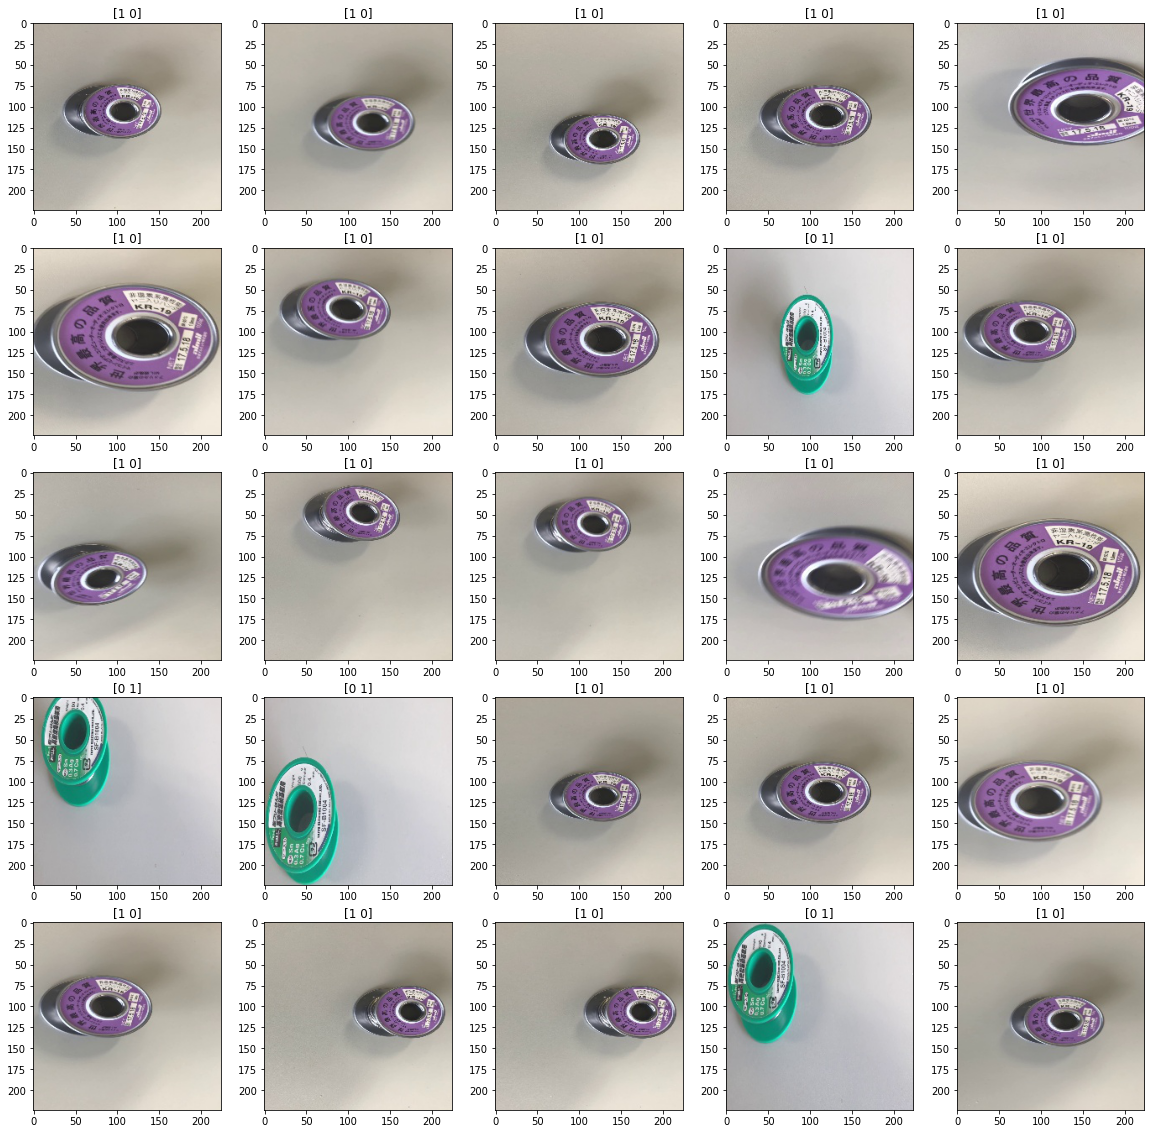

In [8]:
#5x5枚の画像を表示する
plt.figure(figsize=(20,20))
for i in range(25):
    rand_num=np.random.randint(0,1000)
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(xdata[rand_num])
    #x軸の目盛りを消す
    plt.tick_params(labelbottom='off')
    #y軸の目盛りを消す
    plt.tick_params(labelleft='off')
    #正解ラベルを表示
    plt.title(ydata[rand_num])
plt.show()

画像がコマ切れで表示されていると思います。
今回はこれを学習していこうと思います。

---

## モデルを定義してみる

学習モデルを定義していきます。今回はVGG16というモデルを使って転移学習というものを試していきたいと思います。転移学習というものは優秀な学習済みモデルの畳み込みフィルタやpoolingなどを利用して、最後の出力層のみを学習するというものでこれを用いることで、素早く高い精度を出すことが可能になっています。

またVGG16は画像処理のコンペティション(競技)でいい成績を出せたとてもいいモデルです。このモデルをimagenetと呼ばれる超大量のデータセット群で学習した後のモデルを利用して今回は転移学習を行っていきます。

- VGGモデルシリーズの解説 - [Keras：VGG16、VGG19とかってなんだっけ？？ - Qiita](https://qiita.com/MuAuan/items/86a56637a1ebf455e180)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


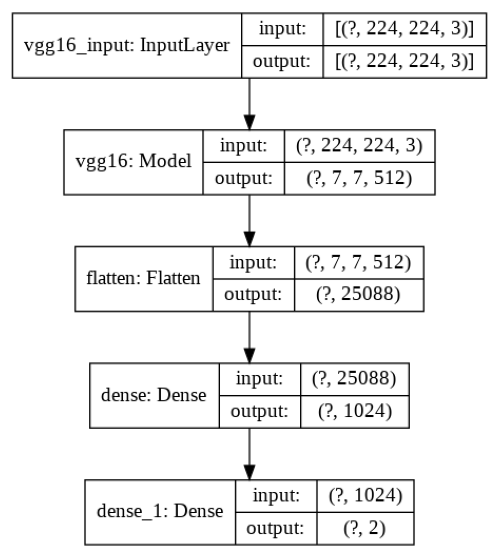

In [9]:
num_classes = 2

vgg16=VGG16(weights='imagenet',include_top=False,
                 input_shape=(224,224,3))

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

#14層目以降を再度学習するように
for layer in vgg16.layers[:15]:
    layer.trainable=False

model.compile(optimizer=keras.optimizers.SGD(lr=0.001,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# モデルアーキテクチャを画像に出力します
%matplotlib inline
plot_model(model, to_file='_.png', show_shapes=True, show_layer_names=True)
im = Image.open('_.png')
plt.figure(figsize=(10,10))
plt.axis('off')
_ = plt.imshow(np.array(im))


---

## 学習を行ってみる

では実際に学習を行っていきたいと思います。
バッチサイズやエポックは今回は少な目で大丈夫です。
バッチサイズは学習データが少ないため、エポックは転移学習である程度学習済みのものを使うため少なめでいいということになってます。

In [12]:
# バッチサイズ
batch_size = 32

# 反復学習する回数
epochs = 1

# 学習の実行
history=model.fit(xdata,ydata,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)

39/39 [==============================] - 651s 17s/step - loss: 2.1227e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


---

## 学習結果を確認する

学習ができたので結果を確認していきましょう
まずは損失率や正解率を確認していきます。


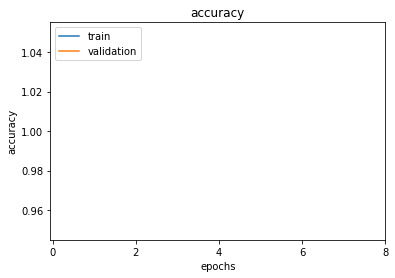

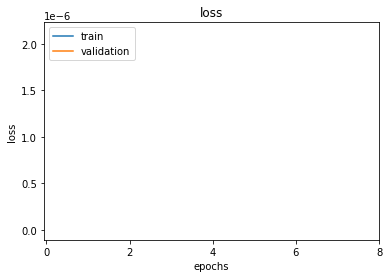

In [13]:
# 正答率と損失関数の値の推移をグラフ化します、
# 学習時の正答率などの情報は、history変数にすべて記録されています。

# 正答率の推移
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.xticks(np.arange(0, 10, 2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 損失関数の推移
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(np.arange(0, 10, 2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

学習できましたか・・・

---

## 実際に推論してみる

推論が正しいのか実際にデータを入れてみて確認してみましょう。


In [14]:
from google.colab import files

uploaded = files.upload()
!ls -l

Saving test.jpg to test.jpg
total 26040
drwxr-xr-x 4 root root     4096 Jul  8 03:53 dataset
-rw-r--r-- 1 root root 12366188 Jul  8 03:49 midori.mp4
-rw-r--r-- 1 root root 13664876 Jul  8 03:53 murasaki.mp4
-rw-r--r-- 1 root root    31323 Jul  8 03:54 _.png
drwxr-xr-x 1 root root     4096 Jun 26 16:26 sample_data
-rw-r--r-- 1 root root   582590 Jul  8 04:41 test.jpg


モデルを推論してみましょう。
Cifar10のおまけと同じような設定です。


predict_classes= 1


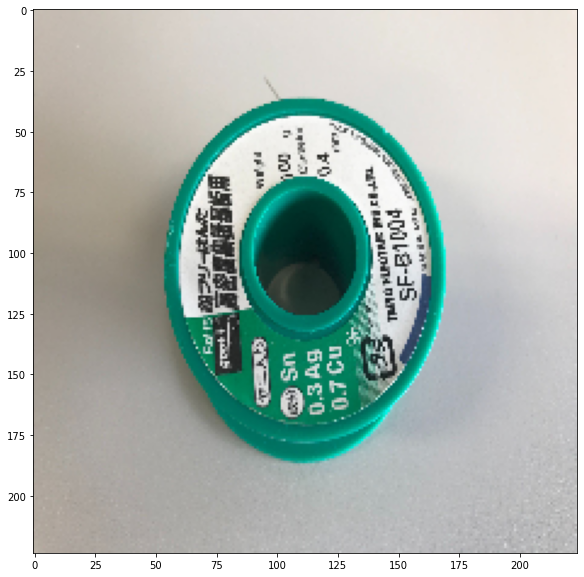

In [21]:
imagename = "./test.jpg"
category = ["0", "1"]

from keras.preprocessing.image import img_to_array, load_img

#画像読み込み
temp_img=load_img(imagename, target_size=(224,224))
#画像を配列に変換し0-1で正規化
temp_img_array=img_to_array(temp_img)
temp_img_array=temp_img_array.astype('float32')/255.0
predict_img_array=temp_img_array.reshape((1,224,224,3))

img_pred=model.predict_classes(predict_img_array)
print('\npredict_classes=', category[img_pred[0]])

plt.figure(figsize=(10,10))
plt.imshow(temp_img_array)
plt.show()